Import primary model as Datagenerator

In [21]:
# Import necessary libraries
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW

# Define the MathDataset class
class MathDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        problem = self.dataframe.iloc[idx]["problem"]
        solution = self.dataframe.iloc[idx]["solution"]

        return problem, solution

# collate_fn function to handle padding and tokenization for a whole batch
def collate_fn(batch):
    problems, solutions = zip(*batch)
    split_token = " =" # has additional space in front as this is a special token
    split_token_id = tokenizer.encode(split_token)[0]

    questions = [f"{p} {s}{tokenizer.eos_token}" for p, s in zip(problems, solutions)] # concatenate and add eos_token

    encoder = tokenizer(
        questions,  # Concatenate problems and solutions for encoding
        padding=True,
        padding_side="left",
        truncation=True,
        max_length=20, # TODO: Adjust max_length based on model
        return_tensors="pt"
    )

    # mask the labels for the solutions
    labels = encoder["input_ids"].clone()
    for i in range(len(problems)):
        # Find the index of the split token in the input_ids
        split_index = (encoder["input_ids"][i] == split_token_id).nonzero(as_tuple=True)[0]
        # Set the labels to -100 for the problem part, so they won't be used in loss calculation
        labels[i][:(split_index+1)] = -100

    return {
        "input_ids": encoder["input_ids"],
        "attention_mask": encoder["attention_mask"],
        "labels": labels,  # Use the masked labels for loss calculation
    }


# Load the math dataset
def load_math_data(problem_filename="math_problems.txt", solution_filename="math_solutions.txt"):
    import pandas as pd
    problems = [line.strip() for line in open(problem_filename, "r")]
    solutions = [line.strip() for line in open(solution_filename, "r")]
    return pd.DataFrame({"problem": problems, "solution": solutions})

data = load_math_data("math_problems.txt", "math_solutions.txt")

# split into train and test sets
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_data = data[:train_size]
test_data = data[train_size:]

# Initialize tokenizer and dataset
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '<|pad|>'})  # Explicitly add a special padding token
    tokenizer.pad_token = '<|pad|>'

train_math_dataset = MathDataset(train_data)
test_math_dataset = MathDataset(test_data)

train_data_loader = DataLoader(train_math_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_data_loader = DataLoader(test_math_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [22]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch

# Load the finetuned model and tokenizer
model_path = "finetuned_gpt2_math_epoch_4"
model = GPT2LMHeadModel.from_pretrained(model_path)

# Ensure the model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to generate a solution for a given math problem
def generate_solution(problem, max_length=50):
    model.eval()
    with torch.no_grad():
        # Tokenize the input problem
        input_enc = tokenizer(
            problem,
            return_tensors="pt",
            padding=False,
            truncation=True,
            max_length=max_length
        )
        input_ids = input_enc["input_ids"].to(device)
        attention_mask = input_enc["attention_mask"].to(device)

        # Generate output
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,
            early_stopping=True
        )

        # extract the attention weights
        

        # Decode the generated output
        solution = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        return solution

def generate_with_attentions(problem, max_new_tokens=10):
    model.eval()
    attentions_per_step = []
    generated_ids = []

    # Tokenize the input problem
    input_enc = tokenizer(problem, return_tensors="pt")
    input_ids = input_enc["input_ids"].to(device)
    attention_mask = input_enc["attention_mask"].to(device)

    # Start with the input_ids as the initial sequence
    cur_ids = input_ids
    for step in range(max_new_tokens):
        with torch.no_grad():
            outputs = model(
                input_ids=cur_ids,
                attention_mask=torch.ones_like(cur_ids),
                output_attentions=True,
                return_dict=True
            )
            # Get logits for the last token
            next_token_logits = outputs.logits[:, -1, :]
            # Greedy decoding: pick the most likely next token
            next_token_id = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)
            # Save the attention weights for this step
            attentions_per_step.append([a.cpu() for a in outputs.attentions])
            # Append the generated token
            cur_ids = torch.cat([cur_ids, next_token_id], dim=1)
            generated_ids.append(next_token_id.item())
            # Stop if EOS token is generated
            if next_token_id.item() == tokenizer.eos_token_id:
                break

    # Decode the full sequence (input + generated)
    full_sequence = cur_ids[0].cpu().tolist()
    solution = tokenizer.decode(full_sequence, skip_special_tokens=True)
    return solution, attentions_per_step

In [23]:
example_problem = test_data.iloc[0]["problem"]
solution, attentions = generate_with_attentions(example_problem)

In [24]:
print(f"Problem: {example_problem}")
print(f"Generated Solution: {solution}")

Problem: 49 - 9 =
Generated Solution: 49 - 9 = -2


In [25]:
print(attentions[2][1].shape)

torch.Size([1, 12, 6, 6])


Run the model and extract the attention and calculate the reward

In [26]:
# Cut off the not used solution part
def trim_solution(solution):
    # Find the index of the split token in the solution
    split_token = " ="
    split_index = solution.find(split_token)
    if split_index != -1:
        # Trim the solution to only include the part after the problem
        trimmed_solution = solution[split_index + len(split_token):].strip()
    else:
        trimmed_solution = solution.strip()
    return trimmed_solution

In [27]:
# generate data for the dataset
attention_data = []
reward_data = []

# generate attention reward pairs
for i in range(100): 
    # get problem, model solution and attention weights
    example_problem = test_data.iloc[i]["problem"]
    solution, attentions = generate_with_attentions(example_problem)
    # trim solution for reward calculation
    solution = trim_solution(solution)
    # get the real solution and calculate the reward
    example_solution = test_data.iloc[i]["solution"]
    diff = torch.tensor([abs(float(solution) - float(example_solution) + 1e-6)])
    reward = -torch.log(diff).item()

    # collect for dataset
    attention_data.append(attentions)
    reward_data.append(reward)


In [28]:
print(len(attention_data))
print(len(reward_data))

100
100


In [29]:
# Put data into a dataset for training
# TODO for attention extract number of layer and solution lenght
# TODO Return size with getitem

class AttentionDataset:
    def __init__(self, attentions, rewards):
        self.attentions = attentions
        self.rewards = rewards
        self.dataset_size = len(rewards)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        return self.attentions[idx], self.rewards[idx]
    
def attention_collate_fn(batch):
    attentions, rewards = zip(*batch)
    return list(attentions), torch.tensor(rewards)
    
test_attention_dataset = AttentionDataset(attention_data, reward_data)
test_attention_loader = DataLoader(test_attention_dataset, batch_size=32, shuffle=False, collate_fn=attention_collate_fn)

In [30]:
for batch in test_attention_loader:
    attentions, rewards = batch
    # Process the batch as needed
    print(f"Batch size: {len(attentions)}")
    print(f"Rewards: {rewards}")
    print(f"Attention data len0: {len(attentions)}")
    print(f"Attention data len1: {len(attentions[2])}")
    print(f"Attention data len2: {len(attentions[3][0])}")
    print(f"Attention shape: {attentions[2][1][0].shape}")
    break  # Just to check the first batch

Batch size: 32
Rewards: tensor([-3.7377e+00, -6.8341e+00,  1.3816e+01, -6.9315e-01, -8.5150e+00,
        -6.1159e+00,  1.3816e+01, -4.1589e+00, -3.8712e+00,  1.3816e+01,
        -4.4427e+00, -6.1137e+00,  1.3816e+01, -1.7918e+00, -5.8051e+00,
        -4.7875e+00, -2.9957e+00, -5.7038e+00, -4.3820e+00, -6.8330e+00,
        -3.5264e+00, -2.3026e+00, -3.4012e+00,  1.3816e+01, -6.9315e-01,
        -7.8766e+00,  1.3816e+01, -5.5835e+00, -3.8286e+00, -4.3694e+00,
        -1.6094e+00,  1.0133e-06])
Attention data len0: 32
Attention data len1: 2
Attention data len2: 12
Attention shape: torch.Size([1, 12, 6, 6])


Saving the dataset

In [31]:
import pickle
# TODO: optinally change to json format to make data human readable
# Save the dataset to a file
with open("attention_dataset.pkl", "wb") as f:
    pickle.dump((attention_data, reward_data), f)
# Load the dataset from a file
with open("attention_dataset.pkl", "rb") as f:
    loaded_attention_data, loaded_reward_data = pickle.load(f)
print(f"Loaded dataset size: {len(loaded_reward_data)}")

Loaded dataset size: 100


Dataset adaption

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
import pickle

# load data using pickle
with open("attention_dataset.pkl", "rb") as f:
    """
    attention_data: dimension (num_samples, iteration, layer, 
                                1 #batch during generation, 
                                num_heads, seq_len, seq_len)
    reward_data: list of rewards (num_samples)
    """
    attention_data, reward_data = pickle.load(f)

# AttentionDataset class
class AttentionDataset:
    def __init__(self, attentions, rewards):
        self.attentions = attentions
        self.rewards = rewards
        self.dataset_size = len(rewards)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        return self.attentions[idx], self.rewards[idx]
    
def attention_collate_fn(batch):
    attentions, rewards = zip(*batch)
    return list(attentions), torch.tensor(rewards)

attention_dataset = AttentionDataset(attention_data, reward_data)
attention_loader = DataLoader(attention_dataset, batch_size=32, shuffle=False, collate_fn=attention_collate_fn)

In [33]:
# code to convert the attention data to a graph
import networkx as nx
import numpy as np

# Create the graph structure from the attention weights
def attention_to_graph(attention):
    # Get the number of nodes
    n = attention.shape[-1] # number of tokens

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes from attention
    for i in range(n):
        # TODO: weight dependend on the number of the tokens
        G.add_node(f'token_{i}', weight=attention[i, i])
    
    # Add edges from attention
    for i in range(n):
        for j in range(n):
            if (j < i): # attention masking
                G.add_edge(f'token_{i}', f'token_{j}', weight=attention[i, j])

    # TODO: Check for further aggregation for transformer input
    return G

Attention data shape: torch.Size([4, 4])
Attention data: 100
Attention data: 3
Nodes:
token_0: {'weight': tensor(1.)}
token_1: {'weight': tensor(0.0703)}
token_2: {'weight': tensor(0.0172)}
token_3: {'weight': tensor(0.0466)}

Edges:
token_1 -> token_0: {'weight': tensor(0.9297)}
token_2 -> token_0: {'weight': tensor(0.7762)}
token_2 -> token_1: {'weight': tensor(0.2066)}
token_3 -> token_0: {'weight': tensor(0.4831)}
token_3 -> token_1: {'weight': tensor(0.3801)}
token_3 -> token_2: {'weight': tensor(0.0902)}


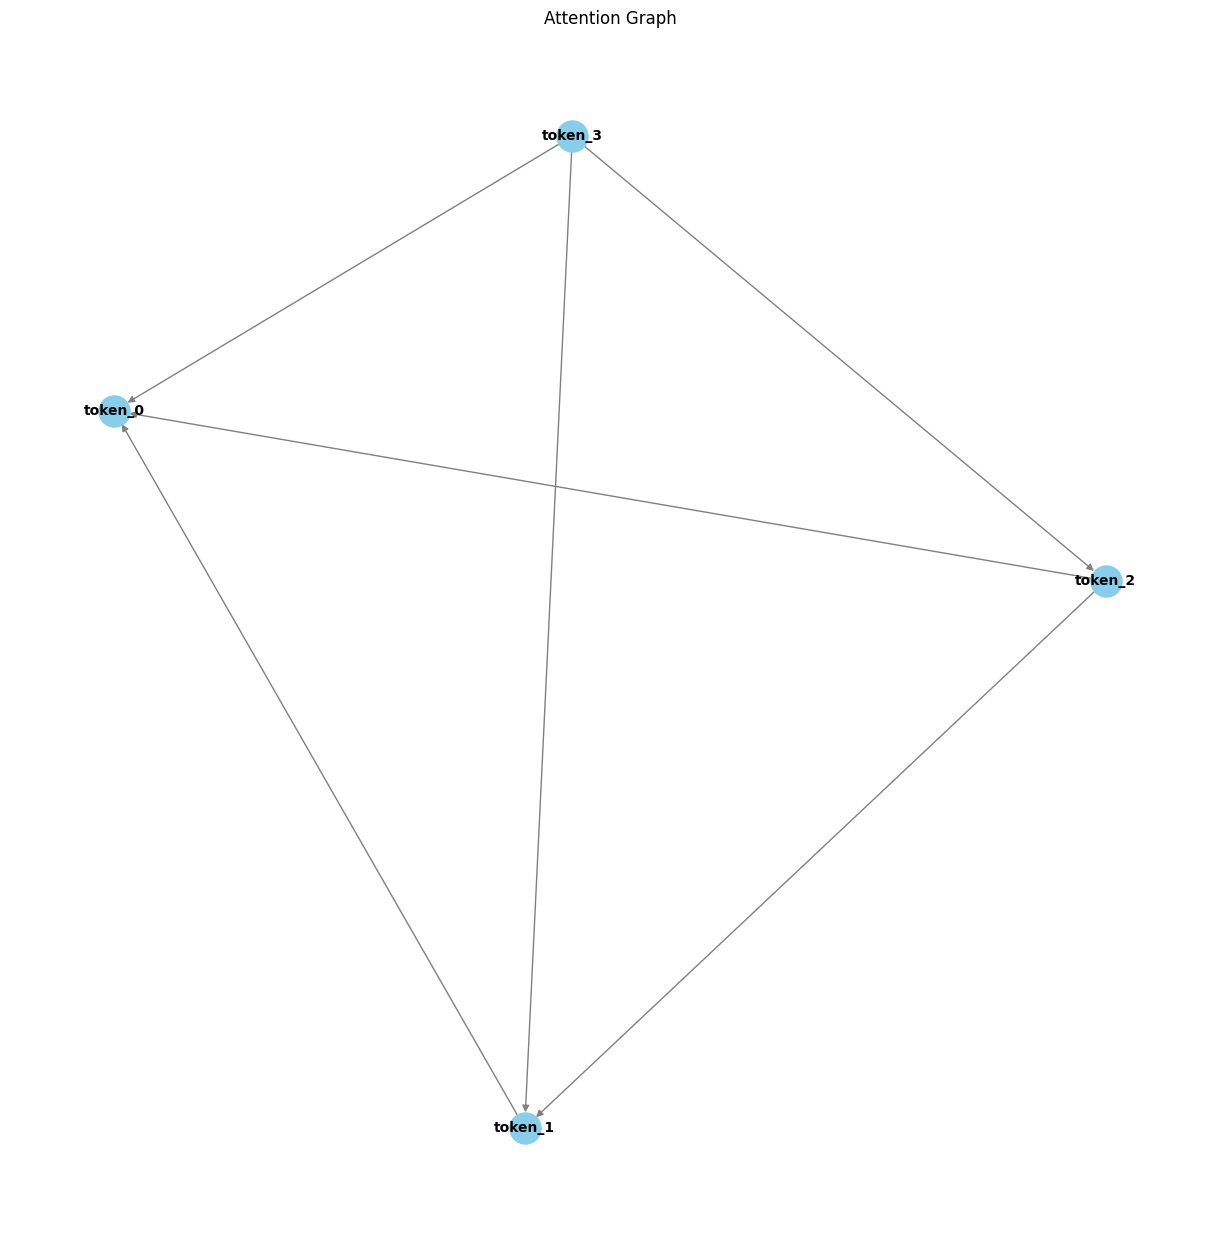

In [34]:
# Test the attention_to_graph function
import matplotlib.pyplot as plt

print("Attention data shape:", attention_data[0][0][0][0][0].shape)  # Check the shape of the attention data
print("Attention data:", len(attention_data))  # Check the attention data
print("Attention data:", len(attention_data[0]))  # Check the attention data
test_graph = attention_to_graph(attention_data[0][0][0][0][0])

def print_graph_details(G):
    print("Nodes:")
    for node, data in G.nodes(data=True):
        print(f"{node}: {data}")
    
    print("\nEdges:")
    for u, v, data in G.edges(data=True):
        print(f"{u} -> {v}: {data}")

print_graph_details(test_graph)

# Function to plot the graph
def plot_graph(G):
    pos = nx.spring_layout(G)  # Layout for visualization
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_weight="bold", edge_color="gray")
    plt.title('Attention Graph')
    plt.show()

plot_graph(test_graph)

In [ ]:
# Test graph creation for a whole batch
# NOTE : This is a deprecated test
# Not correctly functional

attention_graph_data = []
for batch in attention_loader:
    # batch: (num_samples, iteration, layer, 1, num_heads, seq_len, seq_len), rewards: (num_samples)
    attentions, rewards = batch
    attention_data_batch = []
    for attention_iteration in attentions[:]:
        # attention_iteration: (iteration, layer, 1, num_heads, seq_len, seq_len)
        attention_data_step = []
        for attention_layer in attention_iteration[:]:
            # attention_layer: (layer, 1, num_heads, seq_len, seq_len)
            for attention_batch in attention_layer: 
                for attention_head in attention_batch: # TODO: Change data structure to remove the singleton batch dimension
                    attention_data_head = []
                    for attention in attention_head:  
                        # attention_head: (1, num_heads, seq_len, seq_len)
                        G = attention_to_graph(attention)
                        attention_data_head.append(G)
            attention_data_step.append(attention_data_head)
        attention_data_batch.append(attention_data_step)
    attention_graph_data.append(attention_data_batch)
    break

In [41]:
# Check the shape of the attention graph data
print("Attention Graph Data Shape:", len(attention_graph_data))
print("Attention Graph Data:", len(attention_graph_data[0])) # batch
print("Attention Graph Data:", len(attention_graph_data[0][0])) # step
print("Attention Graph Data:", len(attention_graph_data[0][0][0])) # layer
print("Attention Graph Data:", len(attention_graph_data[0][0][0][0]))  # head

Attention Graph Data Shape: 1
Attention Graph Data: 32
Attention Graph Data: 3
Attention Graph Data: 12
Attention Graph Data: 4


In [37]:
print_graph_details(attention_graph_data[0][0][0][0])  # Print details of the first graph
plot_graph(attention_graph_data[0][0][0][0])  # Plot the first graph

Nodes:
token_0: {'weight': tensor([1., 0., 0., 0.])}
token_1: {'weight': tensor([0.8202, 0.1798, 0.0000, 0.0000])}
token_2: {'weight': tensor([0.8162, 0.1402, 0.0436, 0.0000])}
token_3: {'weight': tensor([0.6893, 0.0943, 0.1969, 0.0194])}

Edges:
token_1 -> token_0: {'weight': tensor([1., 0., 0., 0.])}
token_2 -> token_0: {'weight': tensor([1., 0., 0., 0.])}
token_2 -> token_1: {'weight': tensor([0.8669, 0.1331, 0.0000, 0.0000])}
token_3 -> token_0: {'weight': tensor([1., 0., 0., 0.])}
token_3 -> token_1: {'weight': tensor([0.9362, 0.0638, 0.0000, 0.0000])}
token_3 -> token_2: {'weight': tensor([0.6235, 0.2047, 0.1717, 0.0000])}


ValueError: shape mismatch: value array of shape (6,4) could not be broadcast to indexing result of shape (6,)